In [48]:
## Numerical methods
import numpy as np

## Plotting methods
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter

## corner plots
import corner 

In [49]:
## Publication-like style for latex in matplotlib
plt.rcParams["font.family"] = "stix"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"]  = 20
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

In [2]:
import sph_jeans.sph_jeans as sph

In [3]:
from tqdm import tqdm

# Spherical models based on the Jeans Equations.

This version of the Jeans code is currently tailor made for model Globular Cluster with a possible IMBH at its center, but it can easily modified for different objects as the integration of the spherical Jeans equation is independent of the model (within the assumption of constant velocity anisotropy) 

The main goal of the code is to solve the Jeans equation assuming a constant velocity anisotropy, which means it calculates the following integral:

\begin{equation*}
\langle \text{v}^2_r \rangle (r) = \frac{1}{n(r) r^{2\beta}}\int_{r}^{\infty}{dr'n(r')r'^{(2\beta)}\frac{\partial\Phi}{\partial r'}(r')}
\quad\quad\text{(1)}
\end{equation*}

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

## STR
axs[0].plot(r_mods,str_mods[0,0],'-k',lw=2)
axs[1].plot(r_mods,str_mods[0,1],'-k',lw=2)

## PLU
axs[0].plot(r_mods,plu_mods[0,0],'--m',lw=2)
axs[1].plot(r_mods,plu_mods[0,1],'--m',lw=2)

## PLU2
axs[0].plot(r_mods,plu2_mods[0],'-g',lw=2)
axs[1].plot(r_mods,plu2_mods[1],'-g',lw=2)


## NFW
axs[0].plot(r_mods,nfw_mods[0,0],'-.b',lw=2)
axs[1].plot(r_mods,nfw_mods[0,1],'-.b',lw=2)



axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].errorbar(PRF2D[0,0],PRF2D[6,0],yerr=[PRF2D[6,1],PRF2D[6,2]],fmt='or',lw=0.5)
axs[1].errorbar(PRF3D[0,0],PRF3D[15,0],yerr=PRF3D[15,1],fmt='or',lw=0.5)

plt.show()

where $n(r)$ is the tracer  number density (assumed to be the same as the luminosity density $j(r)$), $\beta$ is the radial velocity anisotropy and $\Phi$ is the potential

## Now, how does it work? 

The code create an object called ```model()``` which save all the parameters for the models ```pars```, the luminosity density (tracer density) ```self.nu```, the cumulative mass ```self.mass``` and radial velocity dispersion ```self.s2_r``` (as given by equation (1) )

```python

class model:
    
    def __init__(self,pars):
        self.I0,self.a1,self.a2,self.s0,self.s1,self.s2,self.alph_1,self.alph_2 = pars
         
        #par2 -- tracer density
        self.r  = 10.**np.arange(-3.,8.0,0.1)
        self.nu = np.zeros((self.r).size)    
    
        #par3 -- mass profiles
        self.ml  = 0.0
        self.Mbh = 0.0
        
        self.p0  = 0.0  #scale density for extended dark mass profile
        self.r0  = 0.0  #scale radius for extended dark mass profile
        
        self.mass_tot = np.zeros((self.r).size)
    
        #par4 -- kinematics
        self.beta = 0.0
        self.r_02 = 10.**np.arange(-2.,6.5,0.1)
        self.s2_r = np.zeros((self.r_02).size)    

```



```self.r``` is the radii range for $r'$ in equation (1) and it defines the range of raddi for the tracer density ```self.nu``` and cumulative mass ```self.mass```

In the current version the input parameters ```pars``` are given for the functional form of the surface brightness of the tracers, following this parametric form:

\begin{equation*}
I(R) = I_{0}\times(R/a_0)^{-s_0}\times(1+(R/a_0)^{\alpha_1})^{-s_1/\alpha_1}\times(1+(R/a_1)^{\alpha_2})^{-s_2/\alpha_2}
\quad\quad\text{(2)}
\end{equation*}

where $R$ is the projected radius.

For this example I will use a combination of parameters that its consistent with a Plummer model with a total mass of $M_{tot}=10^5\,M_{\odot}$, a scale radius of $r_0 = 2\,\text{[pc]}$ and a mass-to-light radius of $M/L = 1.5\,[M_{\odot}/L_{\odot}]$. The surface brightness of such Plummer model is:

\begin{equation*}
I(R) = \frac{I_0}{(1+R^2/R_0^2)^2}
\quad\quad\text{(3)}
\end{equation*}

with $I_0 = 5305.16\,[L_{\odot}\text{pc}^{-2}]$ and $R_0 = 2\,\text{[pc]}$


Then input parameters of equation (2) for this model are: 

In [4]:
I0     = 5305.16 
a0     = 1.0
a1     = 2.0
s0     = 0.0
s1     = 0.0
s2     = 4.0
alph_1 = 1.0
alph_2 = 2.0

pars = [I0,a0,a1,s0,s1,s2,alph_1,alph_2]

(see the fit for the surface brightness in "P1 Luminosity Fit Example")

### First step: ```model```

First step, create a model object:

In [5]:
M00 = sph.model(pars)

```M00``` now is the object that will have the input parameters and profiles, you can use ```M00.get_pars()``` to recover the input parameters

In [6]:
M00.get_pars()

[5305.16, 1.0, 2.0, 0.0, 0.0, 4.0, 1.0, 2.0]

### Second step: ```gen_nu()```
The second step is to generate the tracer density using the method ```gen_nu()```

In [7]:
M00.gen_nu()

```gen_nu()``` generates the tracer density (light) and saves it in ```self.nu```. In practice it's not really relevant as you can change the inner part of the code in whatever way you like. In this case the code deprojects the surface brightness calculating this integral:

\begin{equation*}
j(r) = \frac{-1}{\pi}\displaystyle\int_r^{\infty}{\frac{dR}{\sqrt{R^2-r^2}}\frac{dI}{dR}}
\quad\quad\text{(4)}\
\end{equation*}

Once $n(r)$ is created you can extract it by evaluating its value at any given point (within the constraints of the ```self.r```) using ```get_nu(r)```, in the same way you can recover the surface brightness at a given radius with ```I_surf(x)```. 

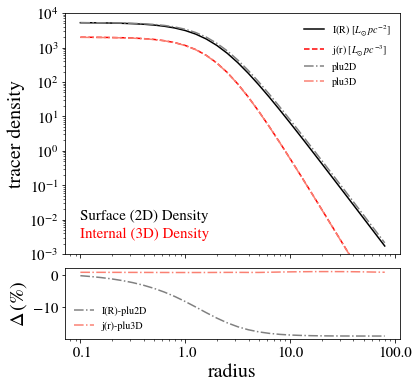

In [47]:
r = 10**np.arange(-1.,2.0,0.1)
R = 10**np.arange(-1.,2.0,0.1)

nu = M00.get_nu(r)
sb = M00.I_surf(R)

## Plummer model, Mtot=1e5, ML = 1.5, r0=2

I0_plummer_2D  = (1e5)/(np.pi*2**2*1.5)
lum_plummer_2D = (1e5/1.5)*(1/(np.pi*(2**2)))*(1+r**2/2**2)**(-2)
lum_plummer_3D = (1e5/1.5)*(3/4)*(1/(np.pi*2**3))*(1+r**2/2**2)**(-5/2)

##Lets see the tracer density profiles:

fig = plt.figure(figsize=(6,6))
gsc = fig.add_gridspec(4,1)
axs = [fig.add_subplot(gsc[:3]),fig.add_subplot(gsc[3])]

axs[0].plot(R,sb,'-k' ,label=r'I(R) [$L_{\odot}\,pc^{-2}$]')
axs[0].plot(r,nu,'--r',label=r'j(r) [$L_{\odot}\,pc^{-3}$]')

axs[0].plot(R,lum_plummer_2D,'-.',c='0.5',label=r'plu2D')
axs[0].plot(r,lum_plummer_3D,'-.',c='salmon',label=r'plu3D')

axs[1].plot(R,(sb-lum_plummer_2D)/lum_plummer_2D*100,'-.',c='0.5',label=r'I(R)-plu2D')
axs[1].plot(r,(nu-lum_plummer_3D)/lum_plummer_3D*100,'-.',c='salmon',label=r'j(r)-plu3D')

axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_yscale('log')

axs[0].xaxis.set_major_formatter(FormatStrFormatter(' '))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))

axs[1].set_xlabel('radius')
axs[0].set_ylabel('tracer density')
axs[1].set_ylabel('$\Delta\,(\%)$')

axs[0].text(0.1,0.01 ,'Surface (2D) Density',color='k',fontsize=15)
axs[0].text(0.1,0.003,'Internal (3D) Density',color='r',fontsize=15)

axs[0].set_ylim([1e-3,1e+4])

###################################
axs[0].legend(frameon=False)
axs[1].legend(frameon=False,loc=3)


####################
plt.show()


### Third step: ```gen_mass(ml,mbh)```

The third step is to generate the cumulative mass profile for the potential. This method uses the already sampled tracer density ```self.nu```, the mass-to-light ratio ```self.ml``` and the mass of the central black hole ```self.Mbh```. The latter two are defined acording the input parameters given to the method. 

In the spherically symetric case, the gradient of the potential $d \Phi/d r$ is given directly by the enclosed mass as:

\begin{equation*}
\frac{d\Phi}{dr} = \frac{GM(r)}{r^2}
\quad\quad\text{(5)}\
\end{equation*}

The method is defined like this:

```python
def gen_mass(self,ml,Mbh):
        self.ml  = ml
        self.Mbh = Mbh
                    
        aux_m_stars = np.zeros(r.size)

        u = np.linspace(r[:-1],r[1:],100)
        v = ml*self.get_nu(u)*u**2
        
        du =      u[1:,:] - u[:-1,:]
        dv = 0.5*(v[1:,:] + v[:-1,:])

        aux_m_stars[1:] = 4*np.pi*np.sum(du*dv,axis=0)

        self.mass_tot = np.cumsum(aux_m_stars) + Mbh
```

where it obtain the total mass by using a trapezoidal rule for the integral:

\begin{equation*}
M(r) = 4\pi\int_{0}^{r}\rho(r')r'^2 dr'
\quad\quad\text{(6)}\
\end{equation*}

As my code asumes a constant mass-to-light ratio then the mass density profile is described by ```ml*self.get_nu(u[j])```

We can generate the cumulative mass profile with the M/L = 1.5 and Mbh = 0.0

In [9]:
M00.gen_mass(1.5,0.0)

Then we can use ```get_mass(r)``` to extract values of the generated cumulative mass profile

In [10]:
mass_plummer = 1e5*(1+2**2/r**2)**(-3/2)

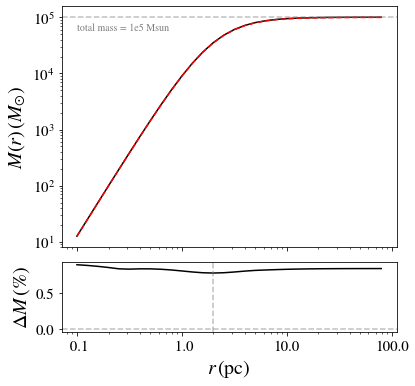

In [50]:
M = M00.get_mass_tot(r)
    
##Lets see the cumulative mass profile:

fig = plt.figure(figsize=(6,6))
gsc = fig.add_gridspec(4,1)
axs = [fig.add_subplot(gsc[:3]),fig.add_subplot(gsc[3])]

axs[0].plot(r,M,'-k')
axs[0].plot(r,mass_plummer,'--r')
axs[0].axhline(y=1e5,ls='--',c='0.5',alpha=0.5)

axs[1].plot(r,(M-mass_plummer)/mass_plummer*100,'-k')
axs[1].axhline(y=0,ls='--',c='0.5',alpha=0.5)
axs[1].axvline(x=2,ls='--',c='0.5',alpha=0.5)


axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].xaxis.set_major_formatter(FormatStrFormatter(' '))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))


axs[1].set_xlabel(r'$r\,(\rm pc)$')
axs[0].set_ylabel(r'$M(r)\,(M_{\odot})$')
axs[1].set_ylabel(r'$\Delta M\,(\%)$')

axs[0].text(0.1,6e4,'total mass = 1e5 Msun',color='0.5')

plt.show()

### 4th step: ```gen_vdisp(ani)```

Now that the tracer density and the mass profile are generated and saved into the object ```M00``` we can integrate the Jeans equation (as eq. (1)). The method ```gen_vdisp(ani)``` receives as an argument a value of velocity anisotropy for the system, save it into the model and generate a radial profile for the square radial velocity dispersion.  

```python
    def gen_vdisp(self,beta):
        self.beta = beta
        r  = self.r_02
        
        ## integration
        x  = np.logspace(np.log10(r),np.log10(r)+max3D,1000)[1:-1,:]
        dx = x[1:,:] - x[:-1,:]

        Ms = self.get_mass_tot(x)
        js = self.get_nu(x)

        ds    = js*x**(2.*beta-2)*G*Ms
        f_mid = 0.5*(ds[1:,:]+ds[:-1,:])*dx       
        
        self.s2_r = np.sum(f_mid,axis=0)*(self.get_nu(r))**(-1)*(r)**(-2*beta)
```

As the other ```gen_``` methods, this one also don't return anything as save the profile directly on the object. Note also that it uses a different radial range than ```self.nu``` and ```self.mass```, the radial range for these two (```self.r```) is larger than ```self.r_02``` wich is the radial range for ```self.s2_r```. Note also that it uses the cumulative mass profile instead of the potential, in this case eq. (1) becomes:

\begin{equation*}
\langle \text{v}^2_r \rangle (r) = \frac{1}{n(r) r^{2\beta}}\int_{r}^{\infty}{dr'n(r')r'^{(2\beta)}\frac{GM(r')}{r'^2}}
\quad\quad\text{(7)}
\end{equation*}

For the isotropic case $\beta=0.0$ we have then:

In [12]:
M00.gen_vdisp(0.0)

In the same way as for the others we can use ```get_s2r(r)``` to get the velocity dispersion at any radius (within the limits of ```self.r_02```)

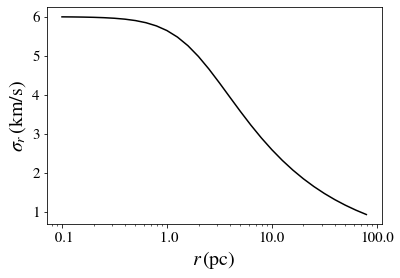

In [61]:
Sr = M00.get_s2r(r)**0.5

##Lets see the cumulative mass profile:

fig,ax = plt.subplots(1,1,sharex=True)

ax.plot(r,Sr,'-k')

ax.set_xscale('log')
ax.xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))


ax.set_xlabel(r'$r\,(\rm pc)$')
ax.set_ylabel(r'$\sigma_{r}\,(\rm km/\rms)$')

plt.show()

### 5th step: Projection on the sky ```I_surf(R)```, ```s_los(R)``` and ```s_pms(R)```

The code has three methods to project the internal (3D) quantities into the sky. These method do a integration along the line-of-sight, the simple case is for the tracer density (in this case light, i.e. luminosity surface density)

```I_surf(R)``` calculates the following integral at a given projected radius $R$ in the sky (from the center of the cluster,galaxy ... etc). The method was used when introducing the calculation of the tracer density on step 2.

\begin{equation*}
I(R) = 2\int_{R}^{\infty}{\frac{r dr}{\sqrt{r^2-R^2}}j(r)}
\quad\quad\text{(8)}
\end{equation*}

```python
def I_surf(self,x):
        r  = np.logspace(np.log10(x),np.log10(x)+maxPJ,1000)[1:-1,:]
        dr = r[1:,:] - r[:-1,:]
        
        js  = self.get_nu(r)

        #integrando Isurf
        A  = r/(r**2-x**2)**0.5*js         
        dI = 0.5*(A[1:,:]+A[:-1,:])*dr
        
        return 2*np.sum(dI,axis=0)

```

```s_los(R)``` and ```s_pms(R)``` follow the same general integral, but with different projection of the velocity dispersion component (see eq. 18 of [van der Marel & Anderson (2010)](https://ui.adsabs.harvard.edu/abs/2010ApJ...710.1063V/abstract), ... or the projections bellow)

\begin{equation*}
\langle\text{v}^2_{\text{PROJ}}\rangle(R)  = \frac{1}{I(R)}\displaystyle\int_{R}^{\infty} \frac{j(r) dr}{\sqrt{r^2-R^2}}\sigma_{PROJ}^2
\quad\quad\text{(9)}
\end{equation*}

where $\sigma^2_{PROJ}$ is given by:

\begin{align}
\sigma_{los}^2 & = \left(1-\beta\times(r/R)^2\right)\langle\text{v}^2_{r}\rangle\ \\
\sigma_{pmr}^2 & = \left(1-\beta+\beta\times(r/R)^2\right)\langle\text{v}^2_{r}\rangle\ \\
\sigma_{pmt}^2 & = \left(1-\beta\right)\langle\text{v}^2_{r}\rangle\
\end{align}

The methods are as follow:

```python
    def s_los(self,x):
        r  = np.logspace(np.log10(x),np.log10(x)+maxPJ,1000)[1:-1,:]
        dr = r[1:,:] - r[:-1,:]

        s2r = self.get_s2r(r)
        js  = self.get_nu(r)

        #integrando Slos
        A = r/(r**2-x**2)**0.5*js        
        B_los = (1.-self.beta*(x/r)**2)*s2r       
        
        f_los = A*B_los

        dS_los = 0.5*(f_los[1:,:]+f_los[:-1,:])*dr
        dI     = 0.5*(A[1:,:]+A[:-1,:])*dr

        aux_slos = np.sum(dS_los,axis=0)
        aux_I = np.sum(dI,axis=0)
        
        #results   
        S_los = np.sqrt(aux_slos/aux_I)

        return S_los
```

```python
def s_pms(self,x):
        r  = np.logspace(np.log10(x),np.log10(x)+maxPJ,1000)[1:-1,:]
        dr = r[1:,:] - r[:-1,:]

        s2r = self.get_s2r(r)
        js  = self.get_nu(r)

        #integrando Slos
        A = r/(r**2-x**2)**0.5*js
        
        B_rad = (1.-self.beta*(1-(x/r)**2))*s2r
        B_tan = (1.-self.beta)*s2r
        
        f_rad = A*B_rad
        f_tan = A*B_tan
        
        dS_rad = 0.5*(f_rad[1:,:]+f_rad[:-1,:])*dr
        dS_tan = 0.5*(f_tan[1:,:]+f_tan[:-1,:])*dr
        dI     = 0.5*(A[1:,:]+A[:-1,:])*dr

        aux_srad = np.sum(dS_rad,axis=0)
        aux_stan = np.sum(dS_tan,axis=0)
        aux_I = np.sum(dI,axis=0)
        
        #results   
        S_rad = np.sqrt(aux_srad/aux_I)
        S_tan = np.sqrt(aux_stan/aux_I)

        return [S_rad,S_tan]
```

Now let's get the projected velocity dispersions

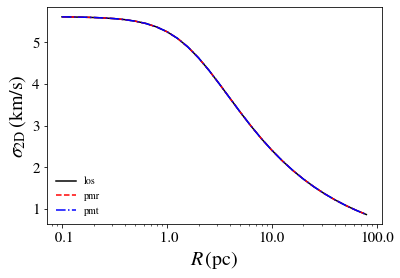

In [62]:
vd_los, vd_pmr, vd_pmt = M00.s_all(R)
    
##The plots are:

fig,ax = plt.subplots(1,1,sharex=True)

ax.plot(R,vd_los,'-k' ,label='los')
ax.plot(R,vd_pmr,'--r',label='pmr')
ax.plot(R,vd_pmt,'-.b',label='pmt')

ax.legend(loc=3,frameon=False)

ax.set_xscale('log')
ax.xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))

ax.set_xlabel(r'$R\,(\rm pc)$')
ax.set_ylabel(r'$\sigma_{\rm 2D}\,(\rm km/\rms)$')

plt.show()

## What if we change the Mbh or the Anisotropy? 

In [15]:
Mtot, ML = 1e5,1.5

In [16]:
ex_mbh = np.array([0.,0.003,0.01,0.05])*Mtot ## no black hole, 0.3%, 1.0% and 5.0%
ex_ani = np.array([-0.5,0.0,+0.5])      ## tangential, isotropic, radial

In [17]:
M01 = sph.model(pars)
M01.gen_nu()

### CENTRAL BLACK HOLE

In [18]:
models_mbh = []

for k in range(ex_mbh.size):
    M01.gen_mass(ML,ex_mbh[k])
    M01.gen_vdisp(0.0) ##All isotropic
    
    aux_sr   = M01.get_s2r(r)**2    
    aux_slos = M01.s_los(R)


        
    models_mbh.append([aux_sr,aux_slos])


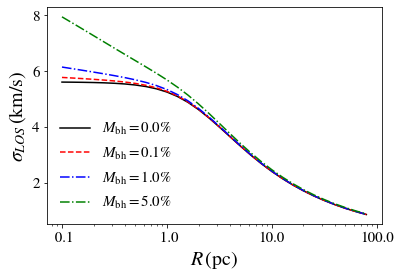

In [67]:
fig,ax = plt.subplots(1,1,sharex=True)

ax.plot(R,models_mbh[0][1],'-k' ,label=r'$M_{\rm bh}=0.0\%$')
ax.plot(R,models_mbh[1][1],'--r',label=r'$M_{\rm bh}=0.1\%$')
ax.plot(R,models_mbh[2][1],'-.b',label=r'$M_{\rm bh}=1.0\%$')
ax.plot(R,models_mbh[3][1],'-.g',label=r'$M_{\rm bh}=5.0\%$')

ax.set_xscale('log')
ax.xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))

ax.legend(loc=3,frameon=False,fontsize=15)

ax.set_xlabel(r'$R\,(\rm pc)$')
ax.set_ylabel(r'$\sigma_{LOS}\,(\rm km/\rm s)$')

plt.show()

### ANISOTROPY

In [20]:
models_ani = []

for k in range(ex_ani.size):
    M01.gen_mass(ML,0.0)      ##No Black Hole
    M01.gen_vdisp(ex_ani[k]) 
    
    aux_sr = M01.get_s2r(r)**2
    
    aux_slos,aux_spmr,aux_spmt = M01.s_all(R)
        
    models_ani.append([aux_sr,aux_slos,aux_spmr,aux_spmt])


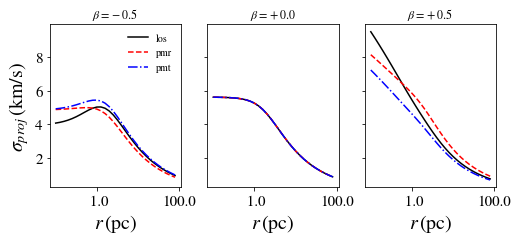

In [69]:
fig,ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(8,3))

for k in range(ex_ani.size):
    ax[k].plot(R,models_ani[k][1],'-k' ,label='los')
    ax[k].plot(R,models_ani[k][2],'--r',label='pmr')
    ax[k].plot(R,models_ani[k][3],'-.b',label='pmt')
    ax[k].set_xlabel(r'$r\,(\rm pc)$')
    ax[k].set_title(r'$\beta = %+4.1lf$'%(ex_ani[k]))

ax[0].set_xscale('log')
ax[0].xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))

ax[0].set_ylabel(r'$\sigma_{proj}\,(\rm km/\rm s)$')
ax[0].legend(frameon=False)

plt.show()

## Fitting for a central IMBH

In [22]:
import sph_jeans.dyn_fit_pms as dyn_fit_pms

In [24]:
PRF2D  = np.load('DATA_IMBH/PRF-IMBH-model.npy')
PRF3D  = np.load('DATA_IMBH/PRF-INT-IMBH-model.npy')
bstLUM = np.load('DATA_IMBH/BEST-IMBH-model.npy') 


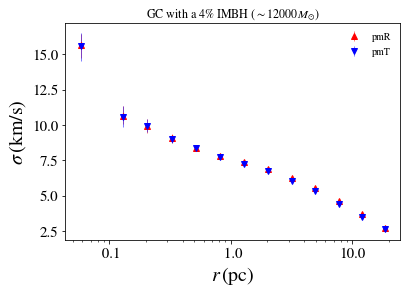

In [73]:
fig,axs = plt.subplots(1,1)

axs.errorbar(PRF2D[0,0],PRF2D[ 8,0],yerr=[PRF2D[ 8,1],PRF2D[ 8,2]],fmt='^r',lw=0.5,label=r'pmR')
axs.errorbar(PRF2D[0,0],PRF2D[10,0],yerr=[PRF2D[10,1],PRF2D[10,2]],fmt='vb',lw=0.5,label=r'pmT')

axs.set_xscale('log')
axs.xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))

axs.set_title(r'GC with a $4\%$ IMBH $(\sim 12000\,M_{\odot})$')

axs.set_xlabel(r'$r\,(\rm pc)$')
axs.set_ylabel(r'$\sigma\, (\rm km/\rm s)$')

axs.legend(loc=1,frameon=False)

######################################################
plt.show()


In [26]:
data_fit   = [PRF2D[0,0],PRF2D[ 8,0],np.amax(PRF2D[ 8,1:],axis=0),PRF2D[10,0],np.amax(PRF2D[10,1:],axis=0)]
init_guess = np.array([1.0,0.0,2.0]) ## ml = 1, beta = 0, logMbh = 2 

In [34]:
imbh_sample_chain, imbh_lnlike_chain = dyn_fit_pms.fit_jeans_imbh(bstLUM, data_fit, init_guess, n_dim = 3, n_walkers = 20, n_steps = 500, progress=True)

100%|██████████| 500/500 [03:14<00:00,  2.56it/s]


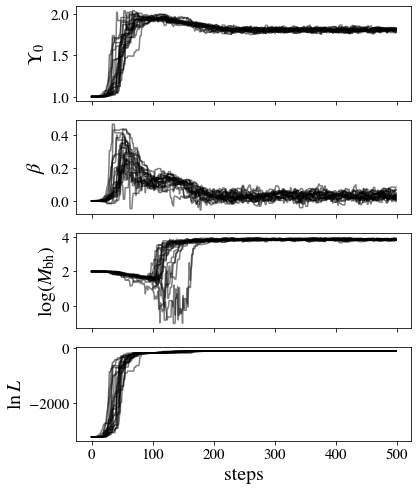

In [74]:
fig,axs = plt.subplots(4,1,figsize=(6,8),sharex=True)

for k in range(imbh_sample_chain.shape[0]):
    axs[0].plot(imbh_sample_chain[k,:,0],'-k',alpha=0.5)
    axs[1].plot(imbh_sample_chain[k,:,1],'-k',alpha=0.5)
    axs[2].plot(imbh_sample_chain[k,:,2],'-k',alpha=0.5)
    axs[3].plot(imbh_lnlike_chain[k,:],'-k',alpha=0.5)

    
axs[0].set_ylabel(r'$\Upsilon_0$')
axs[1].set_ylabel(r'$\beta$')
axs[2].set_ylabel(r'$\log(M_{\rm bh})$')
axs[3].set_ylabel(r'$\ln L$')
axs[3].set_xlabel(r'steps')

plt.show()

In [36]:
n_burn = 400

imbh_samples = imbh_sample_chain[:,n_burn:,:].reshape((-1,imbh_sample_chain.shape[2]))
imbh_loglike = imbh_lnlike_chain[:,n_burn:].reshape((-1))


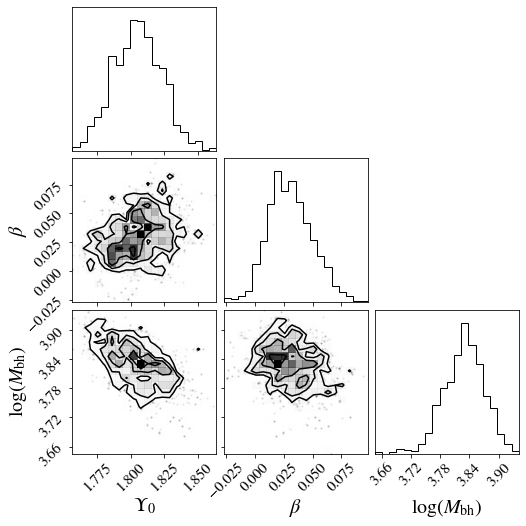

In [75]:
fig = corner.corner(imbh_samples,labels=[r'$\Upsilon_0$',r'$\beta$',r'$\log(M_{\rm bh})$'])

In [38]:
n_mods = 300
r_mods = np.logspace(-1.5,1.5,20)

imbh_idx_choice     = np.zeros(n_mods+1).astype(int)
imbh_idx_choice[0]  = np.argmax(imbh_loglike)
imbh_idx_choice[1:] = np.random.choice(range(imbh_samples.shape[0]),size=n_mods,replace=False)

In [39]:
imbh_mods = np.zeros((n_mods+1,4,r_mods.size))
imbh_pars = np.zeros((n_mods+1,imbh_samples.shape[1]+1))
imbh_chi2 = np.zeros(n_mods+1)

modIMBH = sph.model(bstLUM)
modIMBH.gen_nu()

lumIMBH = modIMBH.I_surf(r_mods)

for k in tqdm(range(n_mods+1)):
    aux_ml,aux_beta,aux_logMbh = imbh_samples[imbh_idx_choice[k]]
    
    imbh_pars[k,:-1] =  imbh_samples[imbh_idx_choice[k]]
    imbh_pars[k,-1]  =  imbh_loglike[imbh_idx_choice[k]]
    
    ## only stars
    modIMBH.gen_mass(aux_ml,0.0)
    imbh_mods[k,2] = modIMBH.get_mass_tot(r_mods)
    
    ## stars + imbh
    modIMBH.gen_mass(aux_ml,10**aux_logMbh)
    imbh_mods[k,3] = modIMBH.get_mass_tot(r_mods)
    
    
    modIMBH.gen_vdisp(aux_beta)
    imbh_mods[k,0], imbh_mods[k,1] = modIMBH.s_pms(r_mods)
    
    ##############################
    #nfw_chi2[k] = np.sum((data_fit[1]-np.interp(data_fit[0],r_mods,nfw_mods[k,0]))**2/data_fit[2]**2)
    

100%|██████████| 301/301 [00:06<00:00, 43.93it/s]


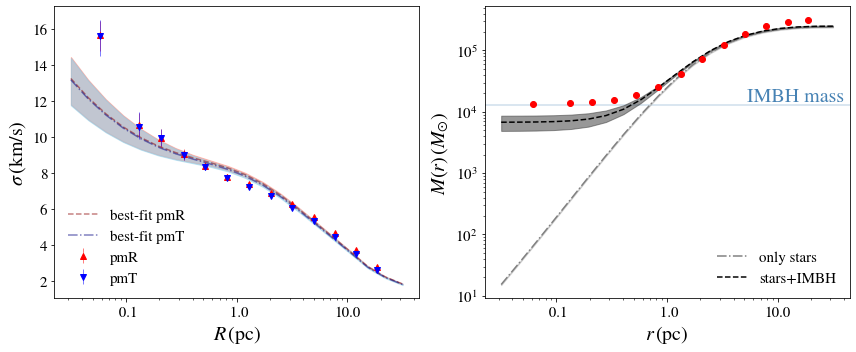

In [83]:
fig,axs = plt.subplots(1,2,figsize=(12,5))

## models
axs[0].fill_between(r_mods,np.percentile(imbh_mods[:,0],0,axis=0),np.percentile(imbh_mods[:,0],100,axis=0),color='salmon',alpha=0.5)
axs[0].fill_between(r_mods,np.percentile(imbh_mods[:,1],0,axis=0),np.percentile(imbh_mods[:,1],100,axis=0),color='skyblue',alpha=0.5)
axs[0].plot(r_mods,imbh_mods[0,0],'--',c='darkred',alpha=0.5,label='best-fit pmR')
axs[0].plot(r_mods,imbh_mods[0,1],'-.',c='navy',alpha=0.5,label='best-fit pmT')
    
axs[1].fill_between(r_mods,np.percentile(imbh_mods[:,2],0,axis=0),np.percentile(imbh_mods[:,2],100,axis=0),color='0.7',alpha=0.5)
axs[1].fill_between(r_mods,np.percentile(imbh_mods[:,3],0,axis=0),np.percentile(imbh_mods[:,3],100,axis=0),color='0.2',alpha=0.5)
axs[1].plot(r_mods,imbh_mods[0,2],'-.',c='0.5',label='only stars')
axs[1].plot(r_mods,imbh_mods[0,3],'--',c='k'  ,label='stars+IMBH')

## IMBH
axs[1].axhline(y=12883.4,ls='-',c='steelblue',lw=2,alpha=0.2,zorder=-1)
axs[1].text(40,12883.4+100,'IMBH mass',verticalalignment='bottom',horizontalalignment='right',fontsize=20,color='steelblue')


## data
axs[0].errorbar(PRF2D[0,0],PRF2D[ 8,0],yerr=[PRF2D[ 8,1],PRF2D[ 8,2]],fmt='^r',lw=0.5,label='pmR')
axs[0].errorbar(PRF2D[0,0],PRF2D[10,0],yerr=[PRF2D[10,1],PRF2D[10,2]],fmt='vb',lw=0.5,label='pmT')

axs[1].errorbar(PRF3D[0,0],PRF3D[15,0],yerr=PRF3D[15,1],fmt='or',lw=0.5)

##
axs[0].legend(loc=3,frameon=False,fontsize=15)
axs[1].legend(loc=4,frameon=False,fontsize=15)

##
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

axs[0].xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))
axs[1].xaxis.set_major_formatter(FormatStrFormatter('%4.1lf'))


##
axs[0].set_xlabel(r'$R\,(\rm pc)$')
axs[0].set_ylabel(r'$\sigma\,(\rm km/\rm s)$')

axs[1].set_xlabel(r'$r\,(\rm pc)$')
axs[1].set_ylabel(r'$M(r)\,(M_{\odot})$')

##
fig.tight_layout()
plt.show()